# 筹码占比因子

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import warnings

In [2]:
# 画出因子分布直方图
def print_factor_dist(data, fac_name):
    data[fac_name].hist(bins=50)
    plt.show()
    print(data[fac_name].min(), data[fac_name].mean(), data[fac_name].max())

In [3]:
# 分组求平均值
def calculate_group_average(data, factor_name, y_name):
    # 将数据按日期排序
    data = data.sort_values('datetime').reset_index(drop=True)
    unique_dates = data['date'].unique()

    # 初始化结果存储
    results_std = pd.DataFrame(columns=['date', factor_name, y_name, 'group_std'])
    results_percent = pd.DataFrame(columns=['date', factor_name, y_name, 'group_percent'])

    # 循环进行训练和测试
    for start_day in range(0, len(unique_dates) - 10, 5):
        pastdays = start_day + 5  # 前5天数据
        futuredays = pastdays + 5  # 接下来的5天数据

        if futuredays >= len(unique_dates):
            break

        # 定义训练集和测试集
        past_data = data[(data['date'] >= unique_dates[start_day]) & (data['date'] <= unique_dates[pastdays])]
        future_data = data[(data['date'] > unique_dates[pastdays]) & (data['date'] <= unique_dates[futuredays])]
        
        # *********************根据标准差分组*********************
        # 计算过去天的势能的标准差
        std_dev = past_data[factor_name].std()
        # mean_val = past_data['apb'].mean()

        # 定义分组区间
        bins_std = [-np.inf, - 3 * std_dev,  - 2 * std_dev,  - std_dev, + std_dev,  + 2 * std_dev,  + 3 * std_dev, np.inf]
        labels_std = ['-∞ to -3σ', '-3σ to -2σ', '-2σ to -σ', '-σ to +σ', '+σ to +2σ', '+2σ to +3σ', '+3σ to +∞']

        temp_std = future_data[['date', factor_name, y_name]].copy()
        temp_std['group_std'] = pd.cut(temp_std[factor_name], bins=bins_std, labels=labels_std)

        # 合并结果并重置索引
        results_std = pd.concat([results_std, temp_std]).reset_index(drop=True)
        
        # *********************根据分位数分组*********************
        # 计算训练集最后天预测值的百分位数
        percentiles = np.percentile(past_data[factor_name], [0, 20, 40, 60, 80, 100])

        # 将预测值按照百分位数分为5组
        bins_percent = percentiles
        labels_percent = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
        
        temp_percent = future_data[['date', factor_name, y_name]].copy()
        temp_percent['group_percent'] = pd.cut(temp_percent[factor_name], bins=bins_percent, labels=labels_percent)

        # 合并结果并重置索引
        results_percent = pd.concat([results_percent, temp_percent]).reset_index(drop=True)
    
    return results_std, results_percent

In [121]:
# 打印分组的结果
def print_grouped_results(data, factor_name, y_name):
    results_std, results_percent = calculate_group_average(data, factor_name, y_name)

    # 计算每组的平均值
    grouped_means_std = results_std.groupby('group_std').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    print(grouped_means_std)
    grouped_means_std[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Standard Deviation)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_std)

    # 计算每组的平均值
    grouped_means_percent = results_percent.groupby('group_percent').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    grouped_means_percent[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Percentage)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_percent)

In [100]:
data = pd.read_csv('data/data_with_minute_returns.csv', dtype={'date': str, 'time': str})
data['datetime'] = pd.to_datetime(data['datetime'])

In [45]:
# 输入：1个股票在1天中的dataframe，
# 输出：pd.series
def doc_kurt(df, timeperiod):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    kurtosis_list = [np.nan] * (timeperiod-1)
    
    # 滚动计算每一行的kurtosis
    for i in range(timeperiod-1, len(df)):
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if len(rolling_returns)<timeperiod:
            kurtosis_list.append(np.nan)
            continue
        
        # 对收益率进行排序
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_vol': rolling_window['tick_vol']
        })
        
        # 按收益率从小到大排序
        temp_df = temp_df.sort_values(by='return')
        
        # 合并大小相同的收益率，求和tick_vol
        merged_returns = temp_df.groupby('return', as_index=False)['tick_vol'].sum()
        
        # 计算kurtosis
        k = kurtosis(merged_returns['tick_vol'], fisher=False)
        kurtosis_list.append(k)
        
    return kurtosis_list

In [ ]:
# 示例DataFrame
data = {
    'mid_px': [100, 102, 101, 103, 105, 104, 106, 108, 110, 109],
    'tick_vol': [200, 220, 180, 250, 300, 270, 320, 350, 400, 380]
}
df = pd.DataFrame(data)

# 测试函数
df['doc_kurt'] = doc_kurt(df, 4)
df

,mid_px,tick_vol,return,doc_kurt
0,100,200,NaN,NaN
1,102,220,NaN,NaN
2,101,180,NaN,NaN
3,103,250,NaN,NaN
4,105,300,0.050000,NaN
5,104,270,0.019608,NaN
6,106,320,0.049505,NaN
7,108,350,0.048544,1.778547
8,110,400,0.047619,1.807979
9,109,380,0.048077,1.586978


In [46]:
def insert_doc_kurt(data):
    results = []
    
    for date, group in data.groupby('date'):
        group = group.copy()
        kurtosis_list = doc_kurt(group, 20)
        group['doc_kurt'] = kurtosis_list
        results.append(group)
    
    result = pd.concat(results)
    return result

In [47]:
data = insert_doc_kurt(data)

/var/folders/s7/0zy1236j02j98tjcntqm6xsc0000gn/T/ipykernel_5780/926218523.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(merged_returns['tick_vol'], fisher=False)
/var/folders/s7/0zy1236j02j98tjcntqm6xsc0000gn/T/ipykernel_5780/926218523.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(merged_returns['tick_vol'], fisher=False)
/var/folders/s7/0zy1236j02j98tjcntqm6xsc0000gn/T/ipykernel_5780/926218523.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(merged_returns['tick_vol'], fisher=False)
/var/folders/s7/0zy1236j02j98tjcntqm6xsc0000gn/T/ipykernel_5780/926218523

In [86]:
data.tail(5)

,Unnamed: 0.1,Unnamed: 0,stk,date,time,tick_vol,tick_amt,spread,mid_px,vwap,...,f3_10,f4_10,datetime,y_1min,y_3min,y_5min,y_7min,y_10min,return,doc_kurt
475400,475400,56305,688981.XSHG,20230711,144947,2479.0,124782.0,0.000199,50.335,50.335619,...,-0.050511,-0.408910,2023-07-11 14:49:47,NaN,NaN,NaN,NaN,NaN,0.000397,4.766077
475401,475401,56306,688981.XSHG,20230711,144950,10839.0,545499.0,0.000199,50.315,50.327429,...,0.004397,-0.260182,2023-07-11 14:49:50,NaN,NaN,NaN,NaN,NaN,0.000000,2.326368
475402,475402,56307,688981.XSHG,20230711,144953,4981.0,250662.0,0.000199,50.325,50.323630,...,-0.007862,-0.164475,2023-07-11 14:49:53,NaN,NaN,NaN,NaN,NaN,0.000199,1.903309
475403,475403,56308,688981.XSHG,20230711,144956,471.0,23701.0,0.000199,50.325,50.320594,...,-0.012469,-0.180835,2023-07-11 14:49:56,NaN,NaN,NaN,NaN,NaN,0.000199,1.721698
475404,475404,56309,688981.XSHG,20230711,144959,200.0,10064.0,0.000199,50.325,50.320000,...,-0.020515,-0.208358,2023-07-11 14:49:59,NaN,NaN,NaN,NaN,NaN,0.000000,1.613400


In [87]:
data.iloc[2360:2365]

,Unnamed: 0.1,Unnamed: 0,stk,date,time,tick_vol,tick_amt,spread,mid_px,vwap,...,f3_10,f4_10,datetime,y_1min,y_3min,y_5min,y_7min,y_10min,return,doc_kurt
2360,2360,55221,688981.XSHG,20230110,143956,300.0,12471.0,0.000241,41.565,41.570000,...,0.501361,-0.049697,2023-01-10 14:39:56,0.000962,0.000481,0.000361,NaN,NaN,0.00000,1.0
2361,2361,55222,688981.XSHG,20230110,144002,200.0,8312.0,0.000241,41.565,41.560000,...,0.519307,-0.044419,2023-01-10 14:40:02,0.000601,0.000481,0.000241,NaN,NaN,0.00000,NaN
2362,2362,55224,688981.XSHG,20230110,144008,19600.0,814471.0,0.000481,41.560,41.554643,...,0.573965,0.050185,2023-01-10 14:40:08,0.000722,0.000842,0.000361,NaN,NaN,-0.00012,1.0
2363,2363,55225,688981.XSHG,20230110,144011,1934.0,80377.0,0.000241,41.565,41.559979,...,0.576984,0.014075,2023-01-10 14:40:11,0.000601,0.000722,0.000241,NaN,NaN,0.00000,1.0
2364,2364,55226,688981.XSHG,20230110,144014,232.0,9645.0,0.000241,41.565,41.573276,...,0.597395,-0.016717,2023-01-10 14:40:14,0.000601,0.000722,0.000241,NaN,NaN,0.00000,1.0


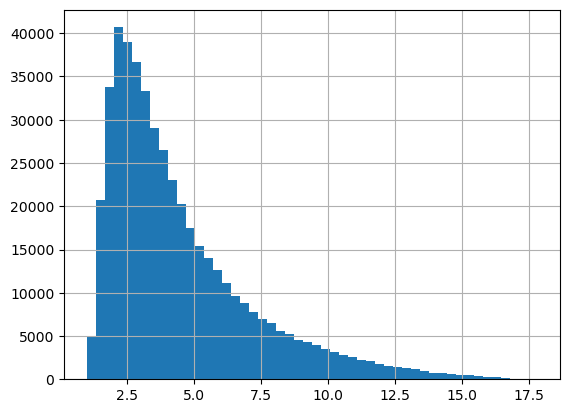

0.9999999999999998 4.485180326703884 17.83140044693212


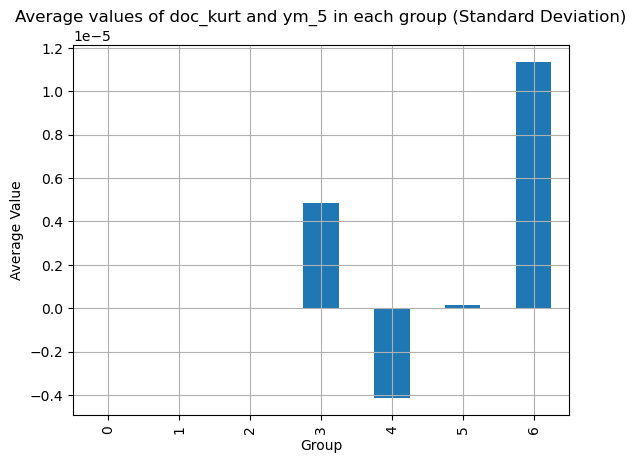

    group_std   doc_kurt          ym_5
0   -∞ to -3σ        NaN           NaN
1  -3σ to -2σ        NaN           NaN
2   -2σ to -σ        NaN           NaN
3    -σ to +σ   2.105772  4.844766e-06
4   +σ to +2σ   3.766402 -4.133668e-06
5  +2σ to +3σ   6.427108  1.466059e-07
6   +3σ to +∞  10.276693  1.134380e-05


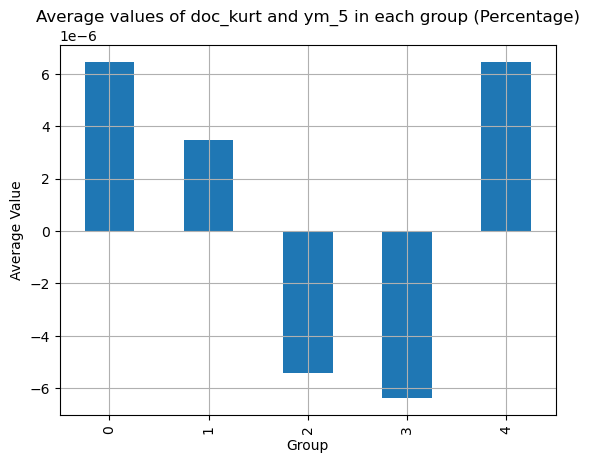

  group_percent  doc_kurt      ym_5
0         0-20%  1.952316  0.000006
1        20-40%  2.762050  0.000003
2        40-60%  3.711116 -0.000005
3        60-80%  5.210804 -0.000006
4       80-100%  8.897329  0.000006


In [88]:
data1 = data.dropna(subset=['doc_kurt'])
print_factor_dist(data1, 'doc_kurt')
print_grouped_results(data1, 'doc_kurt', 'ym_5')

In [83]:
# 输入：1个股票在1天中的dataframe，
# 输出：pd.series
def doc_kurt1(df, timeperiod):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    kurtosis_list = [np.nan] * (timeperiod-1)
    
    # 滚动计算每一行的kurtosis
    for i in range(timeperiod-1, len(df)):
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if len(rolling_returns)<timeperiod:
            kurtosis_list.append(np.nan)
            continue
        
        # 对收益率进行排序
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_vol': rolling_window['tick_vol']
        })
        
        # 按收益率从小到大排序
        temp_df = temp_df.sort_values(by='return')
        
        # 合并大小相同的收益率，求和tick_vol
        merged_returns = temp_df.groupby('return', as_index=False)['tick_vol'].sum()
        
        # print(merged_returns)
        
        # 使用 try-except 捕捉 RuntimeWarning
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                k = kurtosis(merged_returns['tick_vol'], fisher=False)
                if len(w) > 0:
                    for warning in w:
                        if issubclass(warning.category, RuntimeWarning):
                            print(f"RuntimeWarning at index {i}:\n {rolling_window[['date','mid_px','return']]}\n {merged_returns}")
        except Exception as e:
            print(f"Exception at index {i}: {e}")
            k = np.nan
        
        # k加入list
        kurtosis_list.append(k)
        
    return kurtosis_list

In [84]:
def insert_doc_kurt1(data):
    results = []
    
    for date, group in data.groupby('date'):
        group = group.copy()
        kurtosis_list = doc_kurt1(group, 20)
        group['doc_kurt'] = kurtosis_list
        results.append(group)
    
    result = pd.concat(results)
    return result

In [85]:
data1 = data[:7000]
data1 = insert_doc_kurt1(data1)

RuntimeWarning at index 2361:
           date  mid_px  return
2342  20230110  41.565     0.0
2343  20230110  41.565     0.0
2344  20230110  41.565     0.0
2345  20230110  41.565     0.0
2346  20230110  41.565     0.0
2347  20230110  41.565     0.0
2348  20230110  41.565     0.0
2349  20230110  41.565     0.0
2350  20230110  41.565     0.0
2351  20230110  41.565     0.0
2352  20230110  41.565     0.0
2353  20230110  41.565     0.0
2354  20230110  41.565     0.0
2355  20230110  41.565     0.0
2356  20230110  41.565     0.0
2357  20230110  41.565     0.0
2358  20230110  41.565     0.0
2359  20230110  41.565     0.0
2360  20230110  41.565     0.0
2361  20230110  41.565     0.0
    return  tick_vol
0     0.0   40031.0
RuntimeWarning at index 2361:
           date  mid_px  return
2342  20230110  41.565     0.0
2343  20230110  41.565     0.0
2344  20230110  41.565     0.0
2345  20230110  41.565     0.0
2346  20230110  41.565     0.0
2347  20230110  41.565     0.0
2348  20230110  41.565     0.

In [77]:
data1.iloc[2350:2370]

,Unnamed: 0.1,Unnamed: 0,stk,date,time,tick_vol,tick_amt,spread,mid_px,vwap,...,f3_10,f4_10,datetime,y_1min,y_3min,y_5min,y_7min,y_10min,return,doc_kurt
2350,2350,55207,688981.XSHG,20230110,143853,2800.0,116396.0,0.000241,41.565,41.570000,...,0.519982,0.716046,2023-01-10 14:38:53,0.000241,0.000481,0.000481,NaN,NaN,0.000000,1.5
2351,2351,55210,688981.XSHG,20230110,143905,600.0,24942.0,0.000241,41.565,41.570000,...,0.517589,0.693187,2023-01-10 14:39:05,0.000241,0.000361,0.000481,NaN,NaN,0.000000,1.5
2352,2352,55211,688981.XSHG,20230110,143908,448.0,18623.0,0.000241,41.565,41.569196,...,0.515489,0.672053,2023-01-10 14:39:08,0.000481,0.000241,0.000481,NaN,NaN,0.000000,1.5
2353,2353,55212,688981.XSHG,20230110,143917,200.0,8314.0,0.000241,41.565,41.570000,...,0.497011,0.574603,2023-01-10 14:39:17,0.000481,0.000241,0.000481,NaN,NaN,0.000000,1.5
2354,2354,55214,688981.XSHG,20230110,143923,2000.0,83120.0,0.000241,41.565,41.560000,...,0.496105,0.383113,2023-01-10 14:39:23,0.000481,0.000241,0.000481,NaN,NaN,0.000000,1.5
2355,2355,55215,688981.XSHG,20230110,143926,4604.0,191388.0,0.000241,41.565,41.569939,...,0.496966,0.310252,2023-01-10 14:39:26,0.000481,0.000241,0.000481,NaN,NaN,0.000000,1.5
2356,2356,55216,688981.XSHG,20230110,143929,2800.0,116396.0,0.000241,41.565,41.570000,...,0.500293,0.271916,2023-01-10 14:39:29,0.000722,0.000241,0.000241,NaN,NaN,0.000000,1.0
2357,2357,55217,688981.XSHG,20230110,143935,200.0,8314.0,0.000241,41.565,41.570000,...,0.499318,0.208650,2023-01-10 14:39:35,0.000601,0.000481,0.000481,NaN,NaN,0.000000,1.0
2358,2358,55218,688981.XSHG,20230110,143938,3000.0,124710.0,0.000241,41.565,41.570000,...,0.498205,0.152752,2023-01-10 14:39:38,0.000601,0.000481,0.000481,NaN,NaN,0.000000,1.0
2359,2359,55219,688981.XSHG,20230110,143944,1467.0,60974.0,0.000241,41.565,41.563736,...,0.498301,0.093295,2023-01-10 14:39:44,0.000601,0.000481,0.000361,NaN,NaN,0.000000,1.0


## doc_skew

In [95]:
from scipy.stats import skew

In [96]:
# 输入：1个股票在1天中的dataframe，
# 输出：pd.series
def doc_skew(df, timeperiod):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    skewness_list = [np.nan] * (timeperiod-1)
    
    # 滚动计算每一行的kurtosis
    for i in range(timeperiod-1, len(df)):
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if len(rolling_returns)<timeperiod:
            skewness_list.append(np.nan)
            continue
        
        # 对收益率进行排序
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_vol': rolling_window['tick_vol']
        })
        
        # 按收益率从小到大排序
        temp_df = temp_df.sort_values(by='return')
        
        # 合并大小相同的收益率，求和tick_vol
        merged_returns = temp_df.groupby('return', as_index=False)['tick_vol'].sum()
        
        # 计算 skewness
        s = skew(merged_returns['tick_vol'])
        skewness_list.append(s)
        
    return skewness_list

In [97]:
# 示例DataFrame
test_data = {
    'mid_px': [100, 102, 101, 103, 105, 104, 106, 108, 110, 109],
    'tick_vol': [200, 220, 180, 250, 300, 270, 320, 350, 400, 380]
}
df = pd.DataFrame(test_data)

# 测试函数
df['doc_skew'] = doc_skew(df, 4)
df

,mid_px,tick_vol,return,doc_skew
0,100,200,NaN,NaN
1,102,220,NaN,NaN
2,101,180,NaN,NaN
3,103,250,NaN,NaN
4,105,300,0.050000,NaN
5,104,270,0.019608,NaN
6,106,320,0.049505,NaN
7,108,350,0.048544,0.000000
8,110,400,0.047619,0.000000
9,109,380,0.048077,-0.185156


In [98]:
def insert_doc_skew(data):
    results = []
    
    for date, group in data.groupby('date'):
        group = group.copy()
        skewness_list = doc_skew(group, 60)
        group['doc_skew'] = skewness_list
        results.append(group)
    
    result = pd.concat(results)
    return result

In [101]:
data = insert_doc_skew(data)

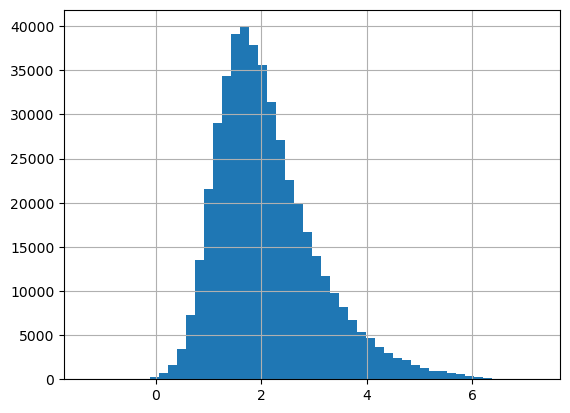

-1.3124178939856115 2.1206854198318057 7.2444874061724365
    group_std  doc_skew          ym_3
0   -∞ to -3σ       NaN           NaN
1  -3σ to -2σ       NaN           NaN
2   -2σ to -σ -1.085402 -1.815463e-05
3    -σ to +σ  0.727618 -3.080501e-06
4   +σ to +2σ  1.481444  5.633922e-07
5  +2σ to +3σ  2.316669  2.670108e-07
6   +3σ to +∞  3.654710  5.064204e-06


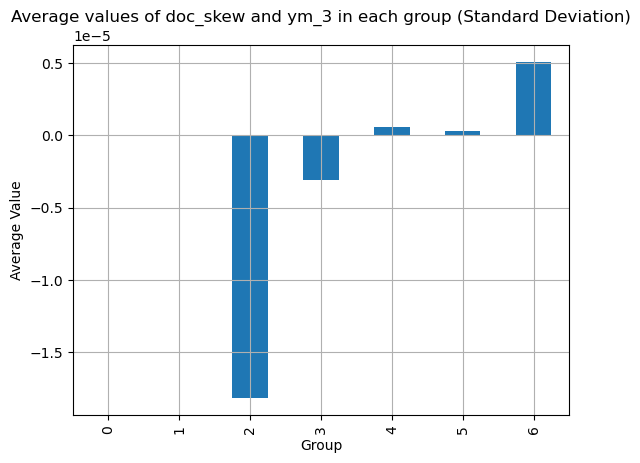

    group_std  doc_skew          ym_3
0   -∞ to -3σ       NaN           NaN
1  -3σ to -2σ       NaN           NaN
2   -2σ to -σ -1.085402 -1.815463e-05
3    -σ to +σ  0.727618 -3.080501e-06
4   +σ to +2σ  1.481444  5.633922e-07
5  +2σ to +3σ  2.316669  2.670108e-07
6   +3σ to +∞  3.654710  5.064204e-06


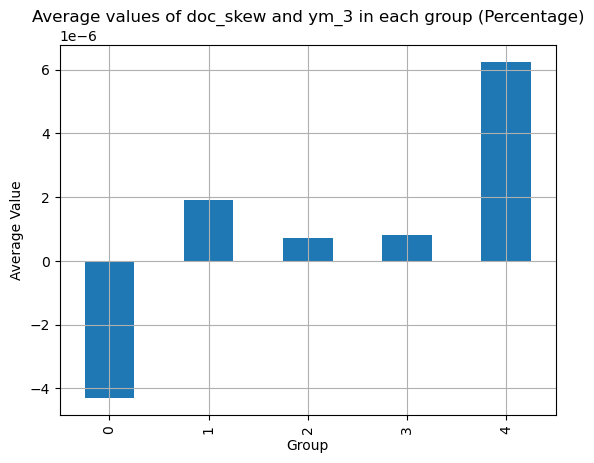

  group_percent  doc_skew          ym_3
0         0-20%  1.044253 -4.307287e-06
1        20-40%  1.551370  1.899395e-06
2        40-60%  1.957205  7.064086e-07
3        60-80%  2.470503  8.208838e-07
4       80-100%  3.616742  6.238653e-06


In [122]:
data1 = data.dropna(subset=['doc_skew'])
print_factor_dist(data1, 'doc_skew')
print_grouped_results(data1, 'doc_skew', 'ym_3')

## doc_vol_pdf60

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475405 entries, 0 to 475404
Data columns (total 32 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0.1  475405 non-null  int64         
 1   Unnamed: 0    475405 non-null  int64         
 2   stk           475405 non-null  object        
 3   date          475405 non-null  object        
 4   time          475405 non-null  object        
 5   tick_vol      475405 non-null  float64       
 6   tick_amt      475405 non-null  float64       
 7   spread        475405 non-null  float64       
 8   mid_px        475405 non-null  float64       
 9   vwap          475405 non-null  float64       
 10  new_price     475405 non-null  float64       
 11  ap1           475405 non-null  float64       
 12  bp1           475405 non-null  float64       
 13  av1           475405 non-null  float64       
 14  bv1           475405 non-null  float64       
 15  ym_3          475

In [116]:
def doc_vol_pdf60(df, timeperiod):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    result_list = [np.nan] * (timeperiod - 1)
    
    # 滚动计算每一行的分位数
    for i in range(timeperiod-1, len(df)):
        
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if rolling_returns.empty:
            result_list.append(np.nan)
            continue
        
        # 创建一个DataFrame来存储收益率和对应的tick_amt
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_amt': rolling_window['tick_amt']
        })
        
        # 对收益率进行排序
        temp_df = temp_df.sort_values(by='return')

        # 合并大小相同的收益率，求和tick_amt
        merged_df = temp_df.groupby('return', as_index=False)['tick_amt'].sum()
        
        # 计算累积成交量
        merged_df['cumsum_amt'] = merged_df['tick_amt'].cumsum()
        
        # 找到60%的那一行
        total_amount = merged_df['tick_amt'].sum()
        threshold_amount = 0.6 * total_amount
        pdf60_return = merged_df.loc[merged_df['cumsum_amt'] >= threshold_amount, 'return'].iloc[0]
        
        # 计算这个收益率在window中的分位数
        p = (rolling_returns <= pdf60_return).mean()
        
        result_list.append(p)
    
    return result_list

In [117]:
def insert_doc_vol_pdf60(data):
    results = []
    
    for date, group in data.groupby('date'):
        group = group.copy()
        result_list = doc_vol_pdf60(group, 60)
        group['doc_vol_pdf60'] = result_list
        results.append(group)
    
    result = pd.concat(results)
    return result

In [126]:
data1 = insert_doc_vol_pdf60(data)

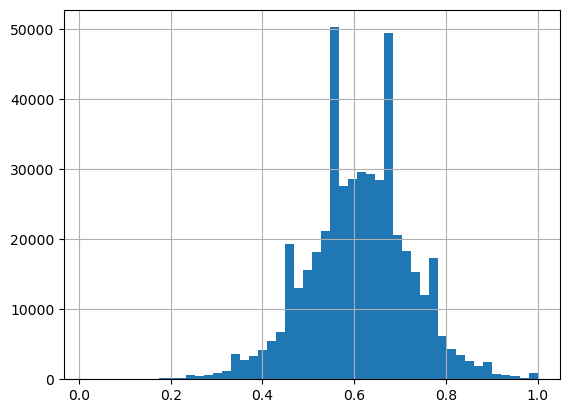

0.016666666666666666 0.6118148872206683 1.0
    group_std  doc_vol_pdf60      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ            NaN       NaN
3    -σ to +σ       0.082692 -0.000231
4   +σ to +2σ       0.194934  0.000029
5  +2σ to +3σ       0.309277 -0.000002
6   +3σ to +∞       0.615006  0.000001


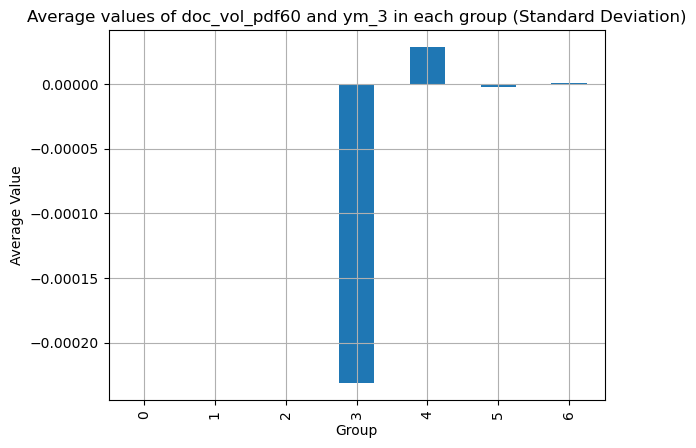

    group_std  doc_vol_pdf60      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ            NaN       NaN
3    -σ to +σ       0.082692 -0.000231
4   +σ to +2σ       0.194934  0.000029
5  +2σ to +3σ       0.309277 -0.000002
6   +3σ to +∞       0.615006  0.000001


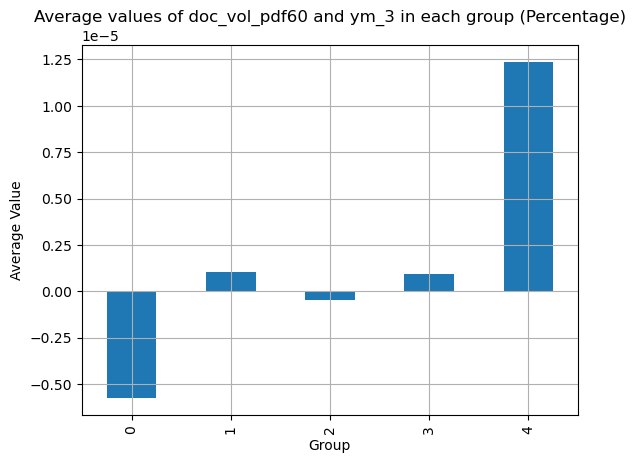

  group_percent  doc_vol_pdf60          ym_3
0         0-20%       0.459664 -5.755415e-06
1        20-40%       0.564944  1.055073e-06
2        40-60%       0.622347 -4.605745e-07
3        60-80%       0.677471  9.449182e-07
4       80-100%       0.770115  1.235909e-05


In [127]:
data2 = data1.dropna(subset=['doc_vol_pdf60'])
print_factor_dist(data2, 'doc_vol_pdf60')
print_grouped_results(data2, 'doc_vol_pdf60', 'ym_3')